# Imports

In [ ]:
import datetime as dt
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so


# Load sensor data

In [ ]:
p = Path('~/My Drive - UW/jirp23_lapse_rate/Data/2023_Season/zero_point_calibration/').expanduser()
paths = list(p.glob('*.csv'))
paths

[PosixPath('/Users/drotto/My Drive - UW/jirp23_lapse_rate/Data/2023_Season/zero_point_calibration/58000000622FFB21_100523.csv'),
 PosixPath('/Users/drotto/My Drive - UW/jirp23_lapse_rate/Data/2023_Season/zero_point_calibration/39000000624A6521_100523.csv'),
 PosixPath('/Users/drotto/My Drive - UW/jirp23_lapse_rate/Data/2023_Season/zero_point_calibration/9E000000624B4121_100523.csv'),
 PosixPath('/Users/drotto/My Drive - UW/jirp23_lapse_rate/Data/2023_Season/zero_point_calibration/CD00000062507721_100523.csv'),
 PosixPath('/Users/drotto/My Drive - UW/jirp23_lapse_rate/Data/2023_Season/zero_point_calibration/370000005FA56721_100523.csv'),
 PosixPath('/Users/drotto/My Drive - UW/jirp23_lapse_rate/Data/2023_Season/zero_point_calibration/03000000625B1B21_100523.csv'),
 PosixPath('/Users/drotto/My Drive - UW/jirp23_lapse_rate/Data/2023_Season/zero_point_calibration/5A000000625D4E21_100523.csv'),
 PosixPath('/Users/drotto/My Drive - UW/jirp23_lapse_rate/Data/2023_Season/zero_point_calibration

In [ ]:
files = []
for p in paths:
    sensor_sn = p.stem.split('_')[0][8:-2]
    d = pd.read_csv(p, skiprows=15, encoding='latin_1')
    d.columns = ['datetime', 'unit', 'T']
    d['datetime'] = pd.to_datetime(d['datetime'])
    d['sensor_sn'] = sensor_sn
    d = d.drop(columns=['unit'])
    files.append(d)
df = pd.concat(files, ignore_index=True)
df

,datetime,T,sensor_sn
0,2023-10-05 14:16:00,25.0,622FFB
1,2023-10-05 14:17:00,24.5,622FFB
2,2023-10-05 14:18:00,24.5,622FFB
3,2023-10-05 14:19:00,24.0,622FFB
4,2023-10-05 14:20:00,24.0,622FFB
...,...,...,...
2807,2023-10-05 15:36:00,14.0,5FADC0
2808,2023-10-05 15:37:00,15.5,5FADC0
2809,2023-10-05 15:38:00,16.5,5FADC0
2810,2023-10-05 15:39:00,17.0,5FADC0


# Visualize & clean

<AxesSubplot:xlabel='datetime', ylabel='T'>

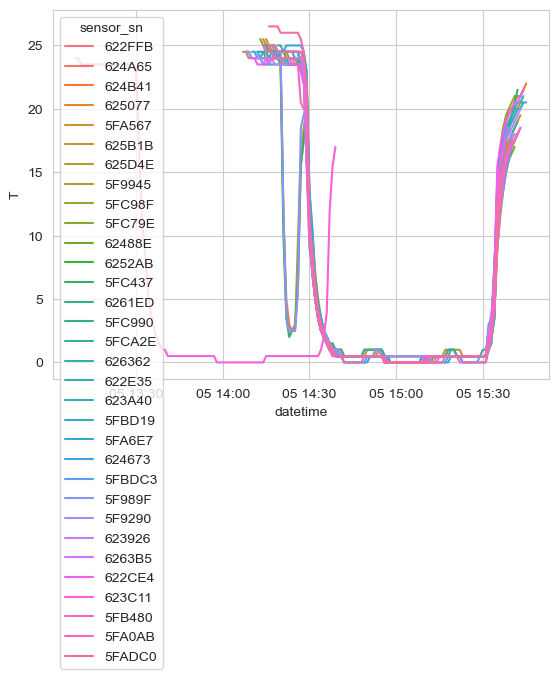

In [ ]:
sns.lineplot(df, x='datetime', y='T', hue='sensor_sn')

Whoops, forgot to sync the clock on one sensor.

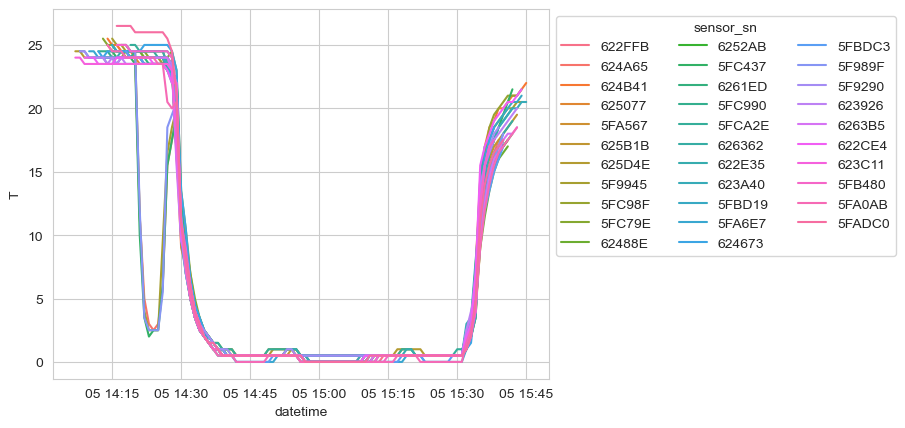

In [ ]:
df.loc[df.sensor_sn == '623C11', 'datetime'] = df.loc[df.sensor_sn == '623C11', 'datetime'] + pd.Timedelta(minutes=58)
fig = sns.lineplot(df, x='datetime', y='T', hue='sensor_sn', legend=True)
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1), ncol=3)

# Results

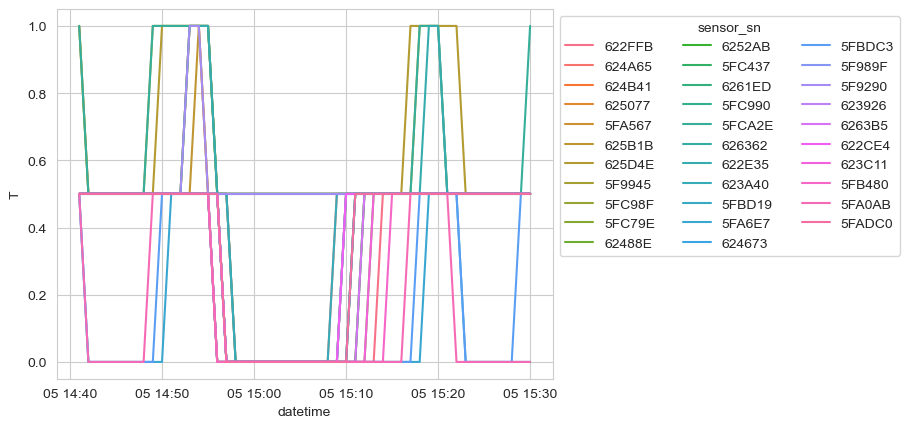

In [ ]:
dt_start = dt.datetime(2023, 10, 5, 14, 40)
dt_end = dt.datetime(2023, 10, 5, 15, 30)

mask = (df.datetime > dt_start) & (df.datetime <= dt_end)
df = df[mask]

fig = sns.lineplot(df, x='datetime', y='T', hue='sensor_sn', legend=True)
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1), ncol=3)

Everything looks pretty good! The 0.5 C sensor resolution results in most sensors recording the same value. There is some spread, but it could be as much a result of the position of the sensor in the ice bath as actual sensor drift.

The water bath probably wasn't perfectly at 0 C, so let's look at the mean over time for all sensors.

/var/folders/bb/wssqxcxj4tgg0s9fdw74731m0000gn/T/ipykernel_90867/21588214.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Tref = df.groupby('datetime').mean()


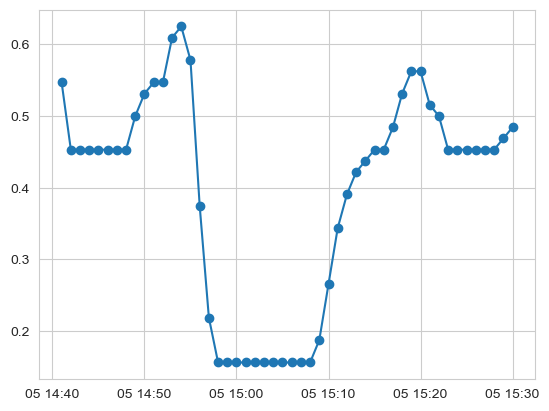

In [ ]:
Tref = df.groupby('datetime').mean()
Tref = Tref.reset_index()

fig, ax = plt.subplots(1,1)
ax.plot(Tref['datetime'], Tref['T'], marker='o')

The ice bath definitely had some temperature variation during the test. The most consistent period is ~14:50 - 15:05. Looking at the plot above, the sensors also seemed to show the most agreement during this period. I interpret the combination of those factors to mean the ice bath was probably the most well mixed during this period. As such, it is likely the most reliable period for assessing drift. However, due to the coarse temperature resolution, there isn't much information to be gleaned except that most of the sensors were reading the same value. The sensors that were reading different values are within our approximate measurement error.

One more thing we can do is look at the spread between sensors over time. Taking our overall mean temperature timeseries as the "true" temperature, we can normalize the readings from each sensor.  

In [ ]:

concat = []
for k, g in df.groupby('sensor_sn'):
    g = g.reset_index(drop=True)
    g['T'] = g['T'] - Tref['T']
    concat.append(g)
Tadj = pd.concat(concat)

print("Mean of adjusted temperatures: ", Tadj['T'].mean())

Mean of adjusted temperatures:  0.0


In [ ]:
Tmean = Tadj.groupby('sensor_sn').mean()
Tmean['T'].describe().apply("{0:.4f}".format)

/var/folders/bb/wssqxcxj4tgg0s9fdw74731m0000gn/T/ipykernel_90867/2689870817.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Tmean = Tadj.groupby('sensor_sn').mean()


count    32.0000
mean     -0.0000
std       0.1295
min      -0.2950
25%      -0.0475
50%      -0.0250
75%       0.1075
max       0.2350
Name: T, dtype: object

With the normalized readings, I then take the mean deviation from our "true" temperature for each sensor over the experiment period. This represents each sensor's "average error", though in reality this error is a combination of experimental error (the position of the sensors in the ice bath), random chance (0.249 C rounds to 0 C, but 0.250 rounds to 0.5 C, aka the real spread may be smaller than it seems), and actual instrument error (i.e., drift).

Our standard deviation is within the sensor's resolution, so we can be pretty sure each sensor is as accurate as the next. The coldest (-0.295) and warmest (0.235) sensors are more than 0.5 C apart, but given the quality of my experimental design, neither of these values are surprising. Overall, my conclusion is that no corrections are needed.


